#Subsección 3.2.1- Ejercicio de simulación-Modelo Conjunto basado en Campos Gaussianos.

*Fecha de última modificación*: 10-oct-22.

*Tesis*: Modelación de la relación entre el cerebro y el comportamiento mediante campos Gaussianos.

*Autor*: Giwon Bahg

*Modificado por*: Daniela Martínez Aguirre

*Descripción*: Código extraido y modificado del repositorio: https://github.com/MbCN-lab/gpjm y https://github.com/rodrigo-carnier/gpjm.

*Figuras*: 2.14 a 2.12.

In [ ]:
#Importamos librerías
!pip install -Uqq ipdb
import ipdb
#Versión utilizada agosto 2022 2.5.2
!pip install gpflow==2.5.2
import numpy as np
import gpflow
import tensorflow as tf
from gpflow.utilities import ops, print_summary  
import numpy as np
import gpflow
import tensorflow as tf
from gpflow.config import set_default_float, default_float, set_default_summary_fmt # 2022-02 RMC upd16: Necessary for setting default num type as float
gpflow.config.set_default_float
set_default_float(np.float64)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#%matplotlib inline      
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()   


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Funciones a utilizar

In [ ]:
#Kernel espacio temporal 
class KernelKronecker_Neural(gpflow.kernels.Kernel):
    def __init__(self, ts_N, ts_B, ss, kernel_temporal = gpflow.kernels.SquaredExponential, kernel_spatial = gpflow.kernels.SquaredExponential):   # 2022-02 RMC upd05: name of this kernel changed from "RBF" to "SquaredExponential"
        super().__init__()                                              # 2022-02 RMC upd04: parameter "input_dim" removed from kernels. 
        self.kernel_t = kernel_temporal()   # 2022-02 RMC upd04: parameter "input_dim" removed from kernels. 
        self.kernel_s = kernel_spatial()                                # 2022-02 RMC upd04: parameter "input_dim" removed from kernels. 
        self.ts_N = ts_N
        self.ts_B = ts_B
        self.ss = ss
        def downsizing_scheme_nearest(ts_N, ts_B):
            M = np.zeros((ts_B.shape[0], ts_N.shape[0]))
            ts = np.squeeze(ts_B)
            for i in range(ts_N.shape[0]):
                argmin_idx = np.argmin(np.abs(ts - ts_N[i,0]))
                M[argmin_idx,i] = 1
            return M
        self.M = tf.constant(downsizing_scheme_nearest(ts_N, ts_B))
        
    def K(self, X, X2=None, presliced=False):
        Xt = X[0]
        Xs = X[1]
        Xt2 = X2[0]
        Xs2 = X2[1]
        kt= self.kernel_t.K(Xt, Xt2)
        kern_temporal =tf.matmul(tf.transpose(self.M), tf.matmul(kt, self.M))
        kern_spatial = self.kernel_s.K(Xs, Xs2)
        # Kronecker product        
        i, k, s = self.ss.shape[0], self.ts_N.shape[0], self.ts_N.shape[0]
        o = s * (i - 1) + k
        Kss  = tf.reshape(kern_spatial, [1, i, i, 1])
        Ktt = tf.reshape(kern_temporal, [k, k, 1, 1])
        Kst = tf.squeeze(tf.nn.conv2d_transpose(Kss, Ktt, (1, o, o, 1), [1, s, s, 1], "VALID"))
        return(Kst)
    
    def K_diag(self, X, X2=None, presliced=False):              # 2022-02 RMC upd07: now when creating a kernel it is necessary to define abstract method "K_diag". For now I'm just copying method "K"
        Xt = X[0]
        Xs = X[1]
        Xt2 = X2[0]
        Xs2 = X2[1]
        kern_temporal = self.kernel_t.K(Xt, Xt2)
        kern_spatial = self.kernel_s.K(Xs, Xs2)
        # Kronecker product        
        i, k, s = self.ss.shape[0], self.ts_N.shape[0], self.ts_N.shape[0]
        o = s * (i - 1) + k
        Kss  = tf.reshape(kern_spatial, [1, i, i, 1])
        Ktt = tf.reshape(kern_temporal, [k, k, 1, 1])
        Kst = tf.squeeze(tf.nn.conv2d_transpose(Kss, Ktt, (1, o, o, 1), [1, s, s, 1], "VALID"))


In [ ]:
#Modelo de campos gaussianos GPJM
class GPJMv4(gpflow.models.GPR):                            # 2022-02 RMC upd06: "gpflow.models.Model" does not exist anymore. Basic template now is "gpflow.models.GPModel", but problems arise.
    def __init__(self, Y_N, Y_B, ts_N, ts_B, n_latent, ss, neural_kernel = KernelKronecker_Neural,
                 kern_tX = None, mean_tX = None, kern_XN = None, mean_XN = None, kern_XB = None, mean_XB = None, name=None):
        if kern_tX is None:
            kern_tX = gpflow.kernels.SquaredExponential()       # 2022-02 RMC upd04: parameter "input_dim" removed from kernels. upd05: name of this kernel changed from "RBF" to "SquaredExponential"
        if mean_tX is None:
            mean_tX = gpflow.mean_functions.Zero(output_dim = n_latent)
        if kern_XN is None:
            kern_XN = neural_kernel(ts_N = ts_N, ts_B = ts_B, ss = ss) # 2022-02 upd04: parameter "input_dim" removed from kernels. 
        if mean_XN is None:
            mean_XN = gpflow.mean_functions.Zero(output_dim = Y_N.shape[1])
        if kern_XB is None:
#             kern_XB = gpflow.kernels.SquaredExponential()     # 2022-02 RMC upd04: parameter "input_dim" removed from kernels. upd05: name of this kernel changed from "RBF" to "SquaredExponential"
            kern_XB = gpflow.kernels.Matern12()         # 2022-02 RMC upd04: parameter "input_dim" removed from kernels. upd15: ARD/ard argument is not passable directly, but directly by lengthscales.
        if mean_XB is None:
            mean_XB = gpflow.mean_functions.Zero(output_dim = Y_B.shape[1])
        #super().__init__(name=name)
        super().__init__((ts_N,Y_N), kernel = KernelKronecker_Neural(ts_N = ts_N, ts_B = ts_B, ss = ss)) # 2022-02 RMC upd18: TODO - use different model since there is no abstract method defined for predict_f. This line here is not correct...
        
        def cubic_interpolation(ts_sparse, Y_N, ts_dense, ss):
            from scipy import interpolate
            yn_new = np.zeros((ts_dense.shape[0], ss.shape[0]))
            yn_array = Y_N.reshape(ss.shape[0], ts_sparse.shape[0]).T
            for i in range(ss.shape[0]):
                temp = interpolate.interp1d(np.squeeze(ts_sparse), yn_array[:,i], kind='cubic', fill_value="extrapolate")
                yn_new[:,i] = temp(np.squeeze(ts_dense))
            return yn_new
        
        def downsizing_scheme_nearest(ts_sparse, ts_dense):
            M = np.zeros((ts_dense.shape[0], ts_sparse.shape[0]))
            ts = np.squeeze(ts_dense)
            for i in range(ts_sparse.shape[0]):
                argmin_idx = np.argmin(np.abs(ts - ts_sparse[i,0]))
                M[argmin_idx,i] = 1
            return M
        
        def HRF_filter(ts_dense):
            ts = np.squeeze(ts_dense)
            unit_ts = ts[ts <= 30]
            def HRFunit(t):
                from scipy.special import gamma
                a1 = 6 # b1=1
                a2 = 16 # b2=1
                c = 1./6
                part1 = t**(a1-1) * np.exp(-t) / gamma(a1)
                part2 = t**(a2-1) * np.exp(-t) / gamma(a2)
                return part1 - c * part2
            hrf = HRFunit(unit_ts)
            return(hrf)
        
        if len(ts_N) > len(ts_B):
            print("Neural: Dense / Behavioral: Sparse")
            self.ts = tf.constant(ts_N.copy())
            self.ts_np = ts_N.copy()
        elif len(ts_N) <= len(ts_B):
            print("Neural: Sparse / Behavioral: Dense")
            self.ts = tf.constant(ts_B.copy())
            self.ts_np = ts_B.copy()
            self.Y_N_interp = cubic_interpolation(ts_N, Y_N, ts_B, ss)
            self.M = downsizing_scheme_nearest(ts_N, ts_B)
        
        # Data
        self.Y_N = tf.constant(Y_N.copy())
        self.Y_B = tf.constant(Y_B.copy())
        self.ts_N = tf.constant(ts_N.copy())
        self.ts_B = tf.constant(ts_B.copy())
        self.ss = tf.constant(ss.copy())
        self.n_Nsample = Y_N.shape[0]
        self.n_Nfeature = Y_N.shape[1]
        self.n_Bsample = Y_B.shape[0]
        self.n_Bfeature = Y_B.shape[1]
        
        # latent dynamics kernel + downsizing scheme
        self.kern_tX = kern_tX
        self.mean_tX = mean_tX
        self.n_latent = n_latent
        self.N_pca = ops.pca_reduce(self.Y_N_interp, n_latent)                  # 2022-02 RMC upd08: method "pca_reduce" moved from "gpflow.models.gpvlm.PCA_reduce" to "gpflow.utilities.ops.pca_reduce"
        self.X = gpflow.Parameter(ops.pca_reduce(self.Y_N_interp, n_latent))    # 2022-02 RMC upd09: call to "PCA_reduce" changed according to upd08
        
        # Neural data kernel
        self.kern_XN = kern_XN
        self.mean_XN = mean_XN
        self.hrf = tf.constant(HRF_filter(self.ts_np))
        
        # Behavioral data kernel
        self.kern_XB = kern_XB
        self.mean_XB = mean_XB

        # Likelihood
        self.likelihood_tX = gpflow.likelihoods.Gaussian()
        self.likelihood_XN = gpflow.likelihoods.Gaussian()
        self.likelihood_XB = gpflow.likelihoods.Gaussian() # Can differ according to the model you rely on.
    
    # @gpflow.params_as_tensors                     # 2022-02 RMC upd01: Parameters are now handled by GPflow. Remove these lines.
    def _build_likelihood_tX(self): # Zero-noise model is not supported by GPflow ==> Need to add an infinitesimal noise when initializing the model.
        Ktx = self.kern_tX.K(self.ts, self.ts) + tf.eye(tf.shape(self.ts)[0],dtype=tf.dtypes.float64) * self.likelihood_tX.variance    # 2022-02 RMC upd17: gpflow does not have attribute "settings" anymore
        Ltx = tf.linalg.cholesky(Ktx)
        mtx = self.mean_tX(self.ts)
        logpdf_tx = gpflow.logdensities.multivariate_normal(self.X, mtx, Ltx)
        return tf.reduce_sum(logpdf_tx)
    
    # @gpflow.params_as_tensors                     # 2022-02 RMC upd01: Parameters are now handled by GPflow. Remove these lines.
    def _build_likelihood_XN(self):
        Kxn = self.kern_XN.K([self.X, self.ss], [self.X, self.ss]) + tf.eye(self.n_Nsample,dtype=tf.dtypes.float64) * self.likelihood_XN.variance     # 2022-02 RMC upd17: gpflow does not have attribute "settings" anymore
        Lxn = tf.linalg.cholesky(Kxn)
        mxn = self.mean_XN(self.Y_N)
        logpdf_xn = gpflow.logdensities.multivariate_normal(self.Y_N, mxn, Lxn)
        return tf.reduce_sum(logpdf_xn)

    # @gpflow.params_as_tensors                     # 2022-02 RMC upd01: Parameters are now handled by GPflow. Remove these lines.
    def _build_likelihood_XB(self):
        Kxb = self.kern_XB.K(self.X, self.X) + tf.eye(tf.shape(self.X)[0],dtype=tf.dtypes.float64) * self.likelihood_XB.variance     # 2022-02 RMC upd17: gpflow does not have attribute "settings" anymore
        Lxb = tf.linalg.cholesky(Kxb)
        mxb = self.mean_XB(self.X)
        logpdf_xb = gpflow.logdensities.multivariate_normal(self.Y_B, mxb, Lxb)
        return tf.reduce_sum(logpdf_xb)

    # @gpflow.name_scope('likelihood')              # 2022-02 RMC upd02: This is not how name_scopes are defined anymore. See 2 lines below.
    # @gpflow.params_as_tensors                     # 2022-02 RMC upd01: Parameters are now handled by GPflow. Remove these lines.
    def maximum_log_likelihood_objective(self):     # 2022-02 RMC upd03: Abstract function for calculating log_likelihood now is named like this. (Was this the purpose of this function "_build_likelihood"?)
        with tf.name_scope('likelihood') as scope:  # 2022-02 RMC upd02: This is how name_scopes are defined nowaways.
            logpdf_tx = self._build_likelihood_tX()
            logpdf_xn = self._build_likelihood_XN()
            logpdf_xb = self._build_likelihood_XB()
            return tf.reduce_sum(logpdf_tx + logpdf_xn + logpdf_xb)

In [ ]:
def row_conv(K, k):
    K2 = np.zeros_like(K)
    for i in range(K.shape[0]):
        K2[i,:] = oneD_conv(K[i,:], k)
    return(K2)

In [ ]:
def row_col_conv(K,k):
    return row_conv(row_conv(K,k).T, k).T

In [ ]:
#Creación de la matriz M Ecuación 3.9
def downsizing_scheme_nearest(ts_N, ts_dense):
  M = np.zeros((ts_dense.shape[0], ts_N.shape[0]))
  ts = np.squeeze(ts_dense)
  for i in range(ts_N.shape[0]):
    argmin_idx = np.argmin(np.abs(ts - ts_N[i,0]))
    M[argmin_idx,i] = 1
  return M


In [ ]:
#Función que simula los datos
def data_gen(ts, ss, theta_cc, theta_ss, theta_bb, sigma2, n_samp, seed = 1):
    sigma2_n = sigma2[0]
    sigma2_b = sigma2[1]
    n_n = n_samp[0]
    n_b = n_samp[1]
    # Latent dynamics kernel
    #cs = np.column_stack([np.squeeze(np.sin(ts)), 2 * np.squeeze((np.sin(ts.T/2.5))**58 + 0.05 * np.sin(ts.T))])
    cs = np.column_stack([np.squeeze(np.sin(ts/8)), np.squeeze(np.sin(ts/4))])
    #Kernel temporal neuronal
    kc=gpflow.kernels.SquaredExponential(variance=theta_cc[0]**2, lengthscales=np.sqrt(theta_cc[1]))
    Kcc = kc(cs, cs).numpy()
    #Kernel comportamiento
    kb=gpflow.kernels.Matern12(variance=theta_bb[0]**2, lengthscales=np.sqrt(theta_bb[1]))
    Kcc_b = kb(cs, cs).numpy()

    #hrf = np.flip(define_HRF_filter_temp())
    #Kcc_conv = row_col_conv(Kcc, hrf)
    # Spatial kernel
    ks=gpflow.kernels.SquaredExponential(variance=theta_ss[0]**2, lengthscales=np.sqrt(theta_ss[1]))
    Kss =ks(ss, ss).numpy()
    Ksc = np.kron(Kss, Kcc)
    # Kronecker kernel
    KIn = Ksc + sigma2_n * np.diag(np.ones(Ksc.shape[0]))
    
    # Generate the data
    np.random.seed(seed)
    yn = np.random.multivariate_normal(np.zeros(Ksc.shape[0]), KIn, n_n).reshape((ss.shape[0], ts.shape[0])).T
    KIb = Kcc_b + sigma2_b * np.diag(np.ones(Kcc.shape[0]))
    np.random.seed(seed)
    yb = np.random.multivariate_normal(np.zeros(Kcc.shape[0]), KIb, n_b)
    #yb = yb - yb.mean()
    return yn, yb,cs



In [ ]:
#Reduce la dimensión de los datos neuronales
def downsample_neuraldata(yn, ts_N, ts_dense):
    M = np.zeros((ts_dense.shape[0], ts_N.shape[0]))
    ts = np.squeeze(ts_dense)
    for i in range(ts_N.shape[0]):
        argmin_idx = np.argmin(np.abs(ts - ts_N[i,0]))
        M[argmin_idx,i] = 1
    m_idx = M.sum(axis=1).astype(bool)
    yn_new = yn[m_idx,:]
    return yn_new, m_idx, M

In [ ]:
#Predicción para la variable latente 
def recover_latent(m, ts_new):
    import tensorflow as tf
    from numpy.linalg import inv, cholesky
    ts = m.ts.numpy()
    Kstar = m.kern_tX(ts, ts_new).numpy()
    KttI = (m.kern_tX(ts, ts) + np.eye(ts.shape[0], dtype=np.float64) * m.likelihood_tX.variance).numpy()
    X = tf.constant(m.X).numpy()
    L = cholesky(KttI)
    return Kstar.T.dot(inv(L.T).dot((inv(L)).dot(X)))

Simulación de datos
GPJM: Simulation Code
Fitting the GPJM to a complete dataset
Here we fit the GPJM to a simulated dataset to test if the GPJM can explain the data appropriately and if it can recover the latent dynamics governing the data generation process.

#Simulación de los datos

In [ ]:
#Tamaño de muestra
N_t = 100

#Puntos en el tiempo donde hay datos neuronales
ts_N = np.linspace(0, N_t, int(N_t/2+1)).reshape(-1, 1)

#Puntos en el tiempo donde de comportamiento
ts = np.linspace(0, N_t, int(3*N_t/2+1)).reshape(-1, 1)

#Creación de los voxels
ss = np.array([(x,y,z) for x in range(3) for y in range(3) for z in range(3)], dtype = np.float64)

In [ ]:
#1. Genera los datos con la función data_gen

yn0, yb, cs= data_gen(ts, ss, [1, 0.75, 0.75], [0.5,0.75], [0.75, 3, 3], [0.015, 0.015], [1, 1])
yn_new, yn_idx, M = downsample_neuraldata(yn0, ts_N, ts)
yn = yn_new.T.ravel().reshape(-1, 1) #yn_new, yn: The actual neural data used in the simulation

In [ ]:
#2. Separación de los datos en entrenamiento y prueba

from sklearn.model_selection import train_test_split
#z=np.append(ts,ts_N)
#z=np.unique(z)
z=np.arange(len(ts))
train_index, test_index=train_test_split(z,  train_size=.8, random_state=1, shuffle=True)
train_index=np.sort(train_index)
test_index=np.sort(test_index)

tsd_train, tsd_test = ts[train_index,:], ts[test_index,:]
tss_train, tss_test = ts[train_index[train_index % 3 == 0]], ts[test_index[test_index % 3 == 0]]
Y_N1_train1=yn_new[(tss_train/2).astype(int)[:,0]]
Y_N1_train=Y_N1_train1.T.ravel().reshape(-1, 1)
Y_B1_train=yb.T[train_index, :]
Y_N1_test1=yn_new[(tss_test/2).astype(int)[:,0]]
Y_N1_test=Y_N1_test1.T.ravel().reshape(-1, 1)
Y_B1_test=yb.T[test_index, :]

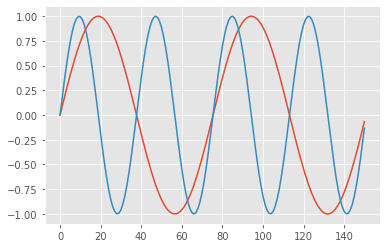

In [ ]:
#Gráfica de la dinámica latente
#Figura 3.8

plt.plot(cs)
#plt.title("Dinámica Latente")
plt.show()

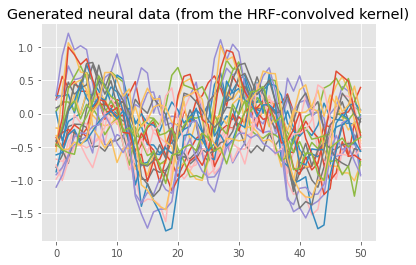

In [ ]:
#Datos neuronales
#Figura 2.9a
plt.plot(yn_new)
plt.title("Generated neural data (from the HRF-convolved kernel)")
plt.show()


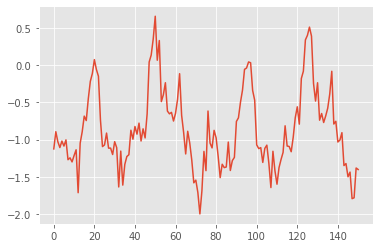

In [ ]:
#Datos de comportamiento
#Figura 3.9b
plt.plot(yb.T)
#plt.title("Observed behavioral data")
plt.show()

#Ajuste del modelo

In [ ]:
# Inicializar el modelo
# Note that the noise parameter of the dynamics kernel and the variance parameter of the spatial kernel are fixed.
test2 = GPJMv4(Y_N1_train, Y_B1_train, tss_train, tsd_train, 2, ss)
test2.likelihood_tX.variance = 1e-6
gpflow.set_trainable(test2.likelihood_tX, False)        # 2022-02 RMC upd11: trainable attributes are not assigned directly anymore, but need a method
#gpflow.set_trainable(test2.kern_XN.kernel_s, False)     # 2022-02 RMC upd11: trainable attributes are not assigned directly anymore, but need a method


Neural: Sparse / Behavioral: Dense


In [ ]:
#Resumen del modelo
test2


name,class,transform,prior,trainable,shape,dtype,value
GPJMv4.kernel.kernel_t.variance,Parameter,Softplus,,True,(),float64,1.0
GPJMv4.kernel.kernel_t.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPJMv4.kernel.kernel_s.variance,Parameter,Softplus,,True,(),float64,1.0
GPJMv4.kernel.kernel_s.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPJMv4.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
GPJMv4.kern_tX.variance,Parameter,Softplus,,True,(),float64,1.0
GPJMv4.kern_tX.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPJMv4.X,Parameter,Identity,,True,"(120, 2)",float64,"[[-0.21307907, -0.78189611..."
GPJMv4.kern_XN.kernel_t.variance,Parameter,Softplus,,True,(),float64,1.0
GPJMv4.kern_XN.kernel_t.lengthscales,Parameter,Softplus,,True,(),float64,1.0


In [ ]:
#Optimización del modelo
#Fit the model to the simulated data.
opt = gpflow.optimizers.Scipy()
print(len(test2.trainable_variables))
#print(test2.trainable_variables.shape)
opt.minimize(test2.training_loss, variables=test2.trainable_variables, allow_unused_variables=True) 
print("2-var done")



16


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Some variables does not have a gradient, and appear unused in / not connected to the loss closure: ['softplus:0', 'softplus:0', 'softplus:0', 'softplus:0', 'chain_of_shift_of_softplus:0'].
  return py_builtins.overload_of(f)(*args)


2-var done


In [ ]:
#Resumen del modelo optimizado
#Tabla 3.4
test2

name,class,transform,prior,trainable,shape,dtype,value
GPJMv4.kernel.kernel_t.variance,Parameter,Softplus,,True,(),float64,1.0
GPJMv4.kernel.kernel_t.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPJMv4.kernel.kernel_s.variance,Parameter,Softplus,,True,(),float64,1.0
GPJMv4.kernel.kernel_s.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPJMv4.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
GPJMv4.kern_tX.variance,Parameter,Softplus,,True,(),float64,9.497724891202862
GPJMv4.kern_tX.lengthscales,Parameter,Softplus,,True,(),float64,13.008464370100052
GPJMv4.X,Parameter,Identity,,True,"(120, 2)",float64,"[[0.02254194, 0.03446739..."
GPJMv4.kern_XN.kernel_t.variance,Parameter,Softplus,,True,(),float64,0.4644005488010391
GPJMv4.kern_XN.kernel_t.lengthscales,Parameter,Softplus,,True,(),float64,0.9341525746333706


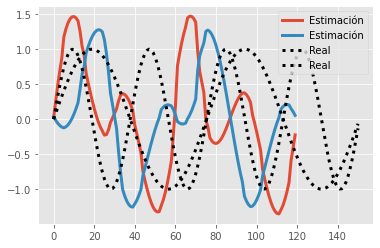

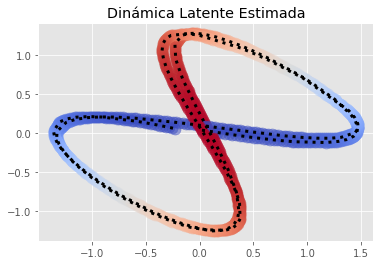

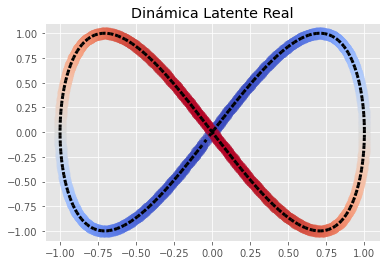

In [ ]:
#Gráficas de la variable latente estimada
import matplotlib.colors as colors
import matplotlib.cm as cm
ts_long = np.linspace(0,100,1000)
ts_long.shape

# Extract the estimated dynamics
latent2 = test2.X

#Time-series plot
#Figura 3.10a
plt.plot( np.asarray(latent2), label="Estimación", linewidth=3)
#plt.plot( np.asarray(latent1), label="Estimación", linewidth=3)
plt.plot(cs, linestyle=":", c="k", linewidth=3, label="Real")
plt.legend()
plt.show()

#Two-dimensional plots
#Figura 3.10b
latent2_0 = np.interp(ts_long, tsd_train.ravel(), latent2[:,0])
latent2_1 = np.interp(ts_long, tsd_train.ravel(), latent2[:,1])

rainbow = plt.get_cmap('coolwarm')
my_norm = colors.Normalize(0, 1)
color_map = cm.ScalarMappable(norm=my_norm, cmap='coolwarm')
col_intensity = np.sin(tsd_train.ravel()/16)**2
col_intensity2 = np.sin(ts_long/16)**2
plt.plot(latent2_0, latent2_1, c="k", linestyle=":", linewidth=3)
for idx in range(ts_long.shape[0]):
    my_col = color_map.to_rgba(col_intensity2[idx], alpha = 0.5)
    plt.scatter(latent2_0[idx], latent2_1[idx], color=my_col, s=125)
plt.title("Dinámica Latente Estimada")
plt.show()

#Figura 3.10c
plt.plot(np.sin(ts_long/8), np.sin(ts_long/4), c="k", linestyle=":", linewidth=3)
for idx in range(ts_long.shape[0]):
    my_col = color_map.to_rgba(col_intensity2[idx], alpha = 0.5)
    plt.scatter(np.sin(ts_long/8)[idx], np.sin(ts_long/4)[idx], color=my_col, s=125)
plt.title("Dinámica Latente Real")
plt.show()


In [ ]:
#Función para recuperar la variable latente
def recover_Kxn(m, ts_new):
    X_new = recover_latent(m, ts_new)
    X = m.X.numpy()[train_index % 3 == 0]
    ss =m.ss.numpy()
    ts_N =m.ts_N.numpy()
    kern_temporal= m.kern_XN.kernel_t(X, X_new)
    #M = tf.constant(downsizing_scheme_nearest(ts_N, ts_new))
    #kern_temporal = tf.matmul(tf.transpose(M), tf.matmul(kt, M)).numpy()
    kern_spatial = m.kern_XN.kernel_s(ss, ss).numpy()
    Kst=np.kron(kern_spatial,kern_temporal)
    return Kst

In [ ]:
#Función para recuperar los datos neuronales
def recover_neural(m, ts_new):
    import tensorflow as tf   
    from numpy.linalg import inv, cholesky
    ts = m.ts.numpy()
    ts_N = m.ts_N.numpy()
    ss = m.ss.numpy()
    Y_N =m.Y_N.numpy()
    Kstar = recover_Kxn(m, ts_new)
    KttI = (recover_Kxn(m, ts_N) + np.eye(Y_N.shape[0], dtype = np.float64) * m.likelihood_XN.variance).numpy()
    L = cholesky(KttI)
    fmean = Kstar.T.dot(inv(L.T).dot((inv(L)).dot(Y_N)))
    v = inv(L).dot(Kstar)
    X_new = recover_latent(m, ts_new)
    kern_temporal= m.kern_XN.kernel_t(X_new, X_new)
    kern_spatial = m.kern_XN.kernel_s(ss, ss).numpy()
    Kstar_new=np.kron(kern_spatial,kern_temporal)
    Vstar = Kstar_new - v.T.dot(v)+np.eye(Kstar_new.shape[0], dtype = np.float64) * m.likelihood_XN.variance
    sd = np.sqrt(np.diag(Vstar))
    return fmean, fmean.ravel().reshape(ss.shape[0], ts_new.shape[0]).T, Vstar, sd.ravel().reshape(ss.shape[0], ts_new.shape[0]).T
yhat2, yhat2_arr, yhat2_v, yhat2_sd = recover_neural(test2, tss_test)

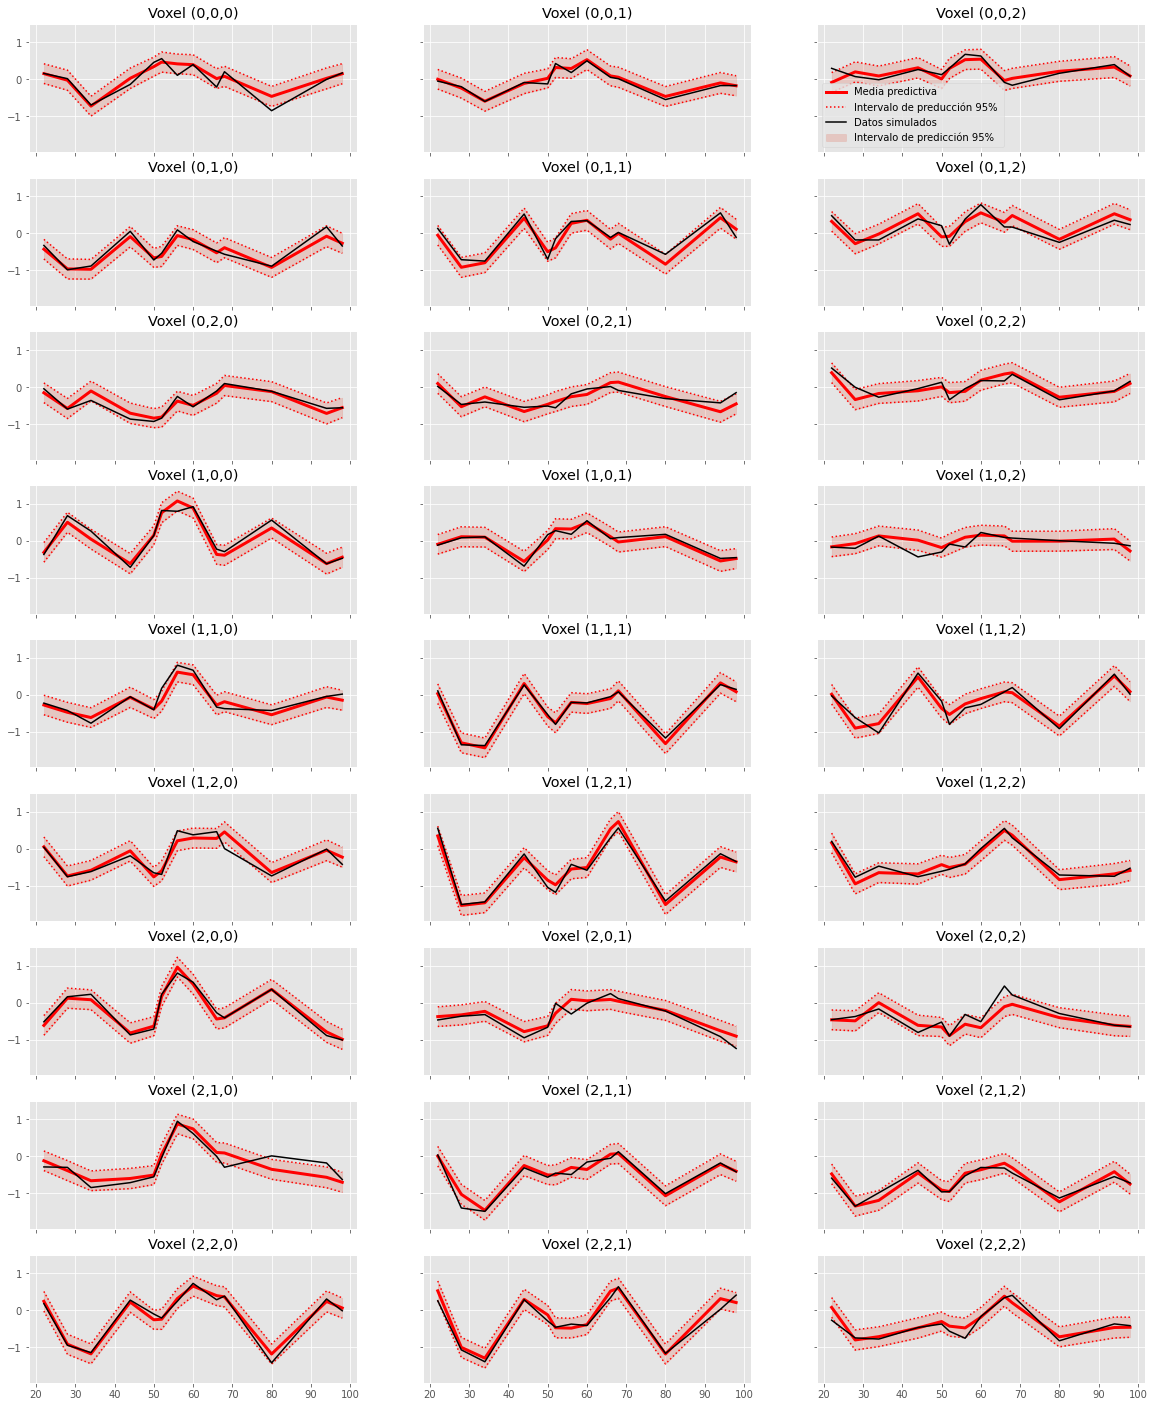

In [ ]:
#Gráfica de los datos neuronales estimados
#Figura 3.12
fig, axs = plt.subplots(9, 3, figsize=(20, 25), sharex=True, sharey = True)
for r in range(9):
    for c in range(3):
        voxel_idx = c+r*3
        axs[r,c].plot(tss_test, yhat2_arr[:,voxel_idx], c="r", label="Media predictiva", linewidth=3)
        axs[r,c].fill_between(tss_test[:,0], yhat2_arr[:,voxel_idx] - 1.96 * yhat2_sd[:,voxel_idx],  yhat2_arr[:,voxel_idx] + 1.96 * yhat2_sd[:,voxel_idx], color="C0", alpha=0.2,label="Intervalo de predicción 95% ")
        axs[r,c].plot(tss_test, yhat2_arr[:,voxel_idx] - 1.96 * yhat2_sd[:,voxel_idx], c="r", linestyle=":", label="Intervalo de preducción 95% ")
        axs[r,c].plot(tss_test, yhat2_arr[:,voxel_idx] + 1.96 * yhat2_sd[:,voxel_idx], c="r", linestyle=":")
        axs[r,c].plot(tss_test, Y_N1_test1[:,voxel_idx], c="k", label="Datos simulados")
        axs[r,c].set_title("Voxel ("+str(int(ss[voxel_idx,0]))+","+str(int(ss[voxel_idx,1]))+","+str(int(ss[voxel_idx,2]))+")")
        if r == 0 and c == 2:
            axs[r,c].legend()

In [ ]:
#Función para recuperar los datos de comportamiento
def recover_behavioral(m, ts_new):
    import tensorflow as tf
    from numpy.linalg import inv, cholesky
    X_new = recover_latent(m, ts_new)
    X = m.X.numpy()
    Kstar = m.kern_XB(X, X_new).numpy()
    KttI = (m.kern_XB(X, X) + np.eye(X.shape[0], dtype = np.float64) * m.likelihood_XB.variance).numpy()
    Y_B = m.Y_B.numpy()
    L = cholesky(KttI)
    fmean = Kstar.T.dot(inv(L.T).dot((inv(L)).dot(Y_B)))
    v = inv(L).dot(Kstar)
    Vstar = m.kern_XB(X_new, X_new).numpy() - v.T.dot(v)+np.eye(X_new.shape[0], dtype = np.float64) * m.likelihood_XB.variance
    ci95 = np.column_stack([fmean - 1.96 * np.sqrt(np.diag(Vstar)).reshape(-1,1), fmean + 1.96 * np.sqrt(np.diag(Vstar)).reshape(-1,1)])
    return fmean, Vstar, ci95

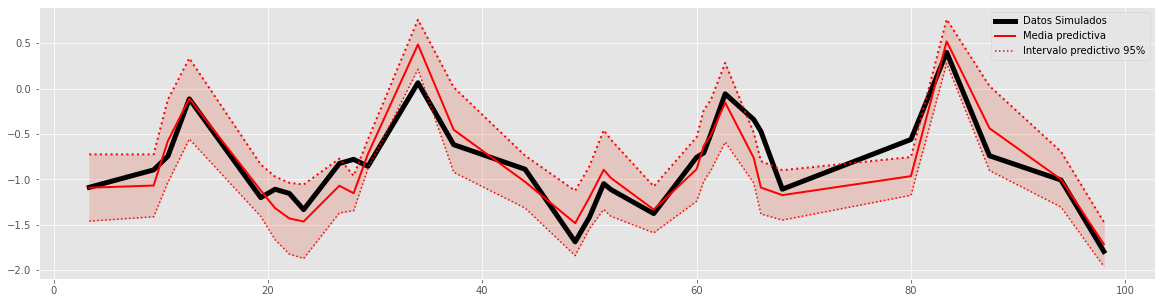

In [ ]:
#Gráfica de los datos de comportamiento estimados
#Figura 3.11
bhat2, _, bhat2_ci = recover_behavioral(test2, tsd_test)
plt.figure(figsize=(20,5))
plt.plot(tsd_test, Y_B1_test.ravel(), c="k", linewidth = 5, label="Datos Simulados")
plt.plot(tsd_test, bhat2, c="r", label = "Media predictiva", linewidth=2)
plt.plot(tsd_test, bhat2_ci[:,0], c="r", linestyle = ":", label="Intervalo predictivo 95%")
plt.plot(tsd_test, bhat2_ci[:,1], c="r", linestyle = ":", linewidth=2)
plt.fill_between(
    tsd_test[:,0],
     bhat2_ci[:,0],
    bhat2_ci[:,1],
    color="C0",
    alpha=0.2
)
plt.legend()
#plt.title("Behavioral Data")
plt.show()